## 0. Introduction

This file contains the description and the code of an analysis around the current most dominant topic of the world: The Corona crisis. It was developed as part of the Udacity education program "Data Scientist". 

**Disclaimer: The entire project and all analysis results MUST NOT be considered as scientifically proven insights about the Corona epidemic. It is a project of an inexperienced student in Data Science and its primary purpose is to 
a) finalize the Udacity Data Science training program, and 
b) to generate some insights about the potential of publicly available data in a world-wide crisis.**

The analysis does follow the "Cross-industry standard process for data mining", in short CRISP-DM process model. Thus the first two chapter of the notebook do contain a summary of "Business Understanding" and "Data Understanding". The further steps of the CRISP-DM model are integrated into each of the 5 questions (see chapter below.)

## 1. Business Understanding

Over the first few month in 2020, the Covid-19/Corona virus pandemic has put the entire world into a serious health, social and economic crisis. The pandemic has spread rapidly, and is still spreading rapidly, across all countries. Most countries have closed their borders and shut down their normal societal and economic life.

The Corona pandemic is omnipresent all over the world and many people are working hard to better understand 

1. how quickly the virus spreads across countries and societies,
2. what measures might have an impact on the infection and/or death growth rate,
3. and what the major implications of the virus pandemic will be. 

The insights resulting from such analysis could then be used by politicians to take decisions on if and how to either loosen or intensify societal and economical restrictions.

The analysis in this project focusses on the following questions:

1. Which sources of trustful data around the Corona pandemic exists?
2. What kind of data is provided in the various sources and how can it be used to help understand, how fast the virus spreads per country?
3. Are there significant differences between countries in how the pandemic develops? And what might be the reasons for these differences?
4. How do the number of Corona infections and Corona deaths correlate with each other? Are there significant differences between countries?
5. How can the implications of the Corona pandemic be measures by data?

## 2. Data Understanding

The first major challenge of such a project is to identify appropriate and trustworthy data sources. 

After investigation of various publically available sources, I have selected the "European Centre for Disease Prevention and Control" (ECDC) as data provider. The agency provides downloadable data files, which are updated daily and contain the latest available public data on COVID-19.

A detailed discussion of potential data sources is included in the COVID-19 data exploration blog.

### Import libraries and gain some first insights about the provided data

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display


The ECDC dataset can be downloaded as CSV file. For this project the data from the 14th of April has been used and stored in the subfolder "data". From there it can be read via the standard Pandas function read_csv.

In [2]:
# Read the ECDC dataset into a Pandas data frame
filename = "data/ECDC_COVID19_20200414.csv"

df_cases = pd.read_csv(filename)

# Show some more information about the data 
df_cases.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,14/04/2020,14,4,2020,58,3,Afghanistan,AF,AFG,37172386.0
1,13/04/2020,13,4,2020,52,0,Afghanistan,AF,AFG,37172386.0
2,12/04/2020,12,4,2020,34,3,Afghanistan,AF,AFG,37172386.0
3,11/04/2020,11,4,2020,37,0,Afghanistan,AF,AFG,37172386.0
4,10/04/2020,10,4,2020,61,1,Afghanistan,AF,AFG,37172386.0


The ECDC dataset contains 10 columns:

+ dateRep: Reporting day inlcuding year and month
+ day: Reporting day
+ month: Reporting month
+ year: Reporing year
+ cases: Number of new infections over the last 24h
+ death: Number of new deaths over the last 24h
+ countriesAndTerritories: Name of the country or territory which reported the number
+ geoId: ID of the reporting country
+ countryterritoryCode: Official country code of the reporting country
+ popData2018: Size of the population of the reporting country

### Check the data types and convert as appropriate

In [3]:
# Check imported data types
print("Data Types before conversion:")
print(df_cases.dtypes)

df_cases.dateRep = pd.to_datetime(df_cases.dateRep, format='%d/%m/%Y')


print("\nData Types after conversion:")
print(df_cases.dtypes)

Data Types before conversion:
dateRep                     object
day                          int64
month                        int64
year                         int64
cases                        int64
deaths                       int64
countriesAndTerritories     object
geoId                       object
countryterritoryCode        object
popData2018                float64
dtype: object

Data Types after conversion:
dateRep                    datetime64[ns]
day                                 int64
month                               int64
year                                int64
cases                               int64
deaths                              int64
countriesAndTerritories            object
geoId                              object
countryterritoryCode               object
popData2018                       float64
dtype: object


### Some statistics to verify the data further.

In [4]:
# Number of rows
print("Overall number of rows in the data set: {}\n\n".format(df_cases.shape[0]))

# What are the first and latest reporint days?
print("First reporting day in the data set: {}".format(min(df_cases['dateRep'])))
print("Latest reporting day in the data set: {}\n\n".format(max(df_cases['dateRep'])))

# Number of current total infections and total death?
print("Number of current total infections: {}".format(sum(df_cases['cases'])))
print("Number of current total deaths: {}\n\n".format(sum(df_cases['deaths'])))

# Number of unique countries or territories
print("Number of unique countries or territories within the data set: {}\n\n".format(df_cases.countriesAndTerritories.nunique()))

# Are there any NaN values in the data set?
print("Number of NaN values per column in the data set: {}\n\n".format(df_cases.isna().sum()))


Overall number of rows in the data set: 10742


First reporting day in the data set: 2019-12-31 00:00:00
Latest reporting day in the data set: 2020-04-14 00:00:00


Number of current total infections: 1873265
Number of current total deaths: 118854


Number of unique countries or territories within the data set: 206


Number of NaN values per column in the data set: dateRep                      0
day                          0
month                        0
year                         0
cases                        0
deaths                       0
countriesAndTerritories      0
geoId                       31
countryterritoryCode       107
popData2018                 67
dtype: int64




Some rows have no geoID, CountryterritoryCode or popData2018. Lets analyse these rows in more detail and adjust as appropriate.

In [5]:
# Show countries and their number of cases / deaths, which do not have a geoID
countries = df_cases[df_cases["geoId"].isnull()]["countriesAndTerritories"].unique()
print("Countries with missing geoId:")
for country in countries:
    print("\t{} with {} cases and {} deaths.".format(country, df_cases[df_cases["countriesAndTerritories"]==country]["cases"].sum(), df_cases[df_cases["countriesAndTerritories"]==country]["deaths"].sum()))

# Show countries and their number of cases / deaths, which do not have a countryterritoryCode
countries = df_cases[df_cases["countryterritoryCode"].isnull()]["countriesAndTerritories"].unique()
print("\nCountries with missing countryterritoryCode:")
for country in countries:
    print("\t{} with {} cases and {} deaths.".format(country, df_cases[df_cases["countriesAndTerritories"]==country]["cases"].sum(), df_cases[df_cases["countriesAndTerritories"]==country]["deaths"].sum()))

# Show countries and their number of cases / deaths, which do not have popData2018
countries = df_cases[df_cases["popData2018"].isnull()]["countriesAndTerritories"].unique()
print("\nCountries with missing popData2018:")
for country in countries:
    print("\t{} with {} cases and {} deaths.".format(country, df_cases[df_cases["countriesAndTerritories"]==country]["cases"].sum(), df_cases[df_cases["countriesAndTerritories"]==country]["deaths"].sum()))


Countries with missing geoId:
	Namibia with 16 cases and 0 deaths.

Countries with missing countryterritoryCode:
	Anguilla with 3 cases and 0 deaths.
	Bonaire, Saint Eustatius and Saba with 4 cases and 0 deaths.
	Cases_on_an_international_conveyance_Japan with 696 cases and 7 deaths.
	Falkland_Islands_(Malvinas) with 5 cases and 0 deaths.

Countries with missing popData2018:
	Anguilla with 3 cases and 0 deaths.
	Bonaire, Saint Eustatius and Saba with 4 cases and 0 deaths.
	Eritrea with 34 cases and 0 deaths.
	Falkland_Islands_(Malvinas) with 5 cases and 0 deaths.


### Data Understanding Results

Overall, the ECDC dataset contains very "clean" and comprehensive data. More than 200 countries are included with a total of 1 873 265 infections and 118 854 deaths (as of April 14th). There are just a few NaN values, and all of them will most likely not have any major impact on the further analysis.

Therefore we will continue the project based on the selected data set.

In [ ]:
l

## Q1: How fast does the pandamic develop per country?

After having identified a trustful data source for the development of infections and deaths, let's see how this data can be used to help understand, how fast the virus spreads per country.



### Data Preparation & Modeling for Q1

The following KPIs shall be evaluated to determine which KPI, or which combination of KPI's is the best one to answer this question:
+ "Growth Rate": Percentage growth of infections / deaths
  + Calcuated as {number of new cases on day x} / {cumulated number of cases up to day x} * 100
+ "Doubling Days": Number of days in which the number of cases doubles
  + Calculated as {cumulated cases up to day x} / {average number of cases over the last 5 days}
+ "Change of Growth Rate": Change rate of the "Growth Rate"
  + Calculated as {average growth rate of (day x-5 up to day x)} / {average growth rate of (day x-6 up to day x-1)}


#### Create two new columns with cumlated cases and deaths

In [124]:
# Step 0: Create a deep copy of the data set to be ready to start from here again
df_cum = df_cases.copy().reset_index()

# Step 1: Make sure the data is properly sorted by country and date
df_cum = df_cum.sort_values(['countriesAndTerritories','dateRep']).reset_index()

# Step 2: Calcluate two additional columns with cumulative cases and deaths
df_cum["cum_cases"] = df_cum.groupby(['countriesAndTerritories', 'dateRep'])["cases", "deaths"].sum().groupby(level=0).cumsum().reset_index()[["cases", "deaths"]]["cases"]
df_cum["cum_deaths"] = df_cum.groupby(['countriesAndTerritories', 'dateRep'])["cases", "deaths"].sum().groupby(level=0).cumsum().reset_index()[["cases", "deaths"]]["deaths"]

# Step 3: Get rid of additional columns created in the steps before
df_cum = df_cum[["dateRep", "day", "month", "year", "cases", "deaths", "countriesAndTerritories", "geoId", "countryterritoryCode", "popData2018", "cum_cases", "cum_deaths"]]

#### Create columns growth_rate_cases and growth_rate_deaths

The formula to be used is {number of new cases on day x} / {cumulated number of cases up to day x} * 100

In [125]:
# Step 0: Create a deep copy of the data set to be ready to start from here again
df_cum_gr = df_cum.copy()

# Step 1: Calculate two new columns based on the formula {number of new cases on day x} / {cumulated number of cases up to day x} * 100
df_cum_gr["growth_rate_cases"] = df_cum[df_cum["cum_cases"]>1]["cases"] / df_cum[df_cum["cum_cases"]>=1]["cum_cases"] * 100
df_cum_gr["growth_rate_deaths"] = df_cum[df_cum["cum_deaths"]>1]["deaths"] / df_cum[df_cum["cum_deaths"]>=1]["cum_deaths"] * 100

#### Create columns double_days_cases and double_days_deaths

The formula to be used is {cumulated cases up to day x} / {average number of cases over the last 5 days}. For each country we first calculate the rolling cumulated cases / deaths per 5 days. Then we apply the before mentioned function.

In [126]:
# Step 1: Get the list of countries
countries = list(df_cum_gr.countriesAndTerritories.unique())

# Step 2: Create the target data frame with two additional columns to hold the rolling cumulated cases per 5 days
new_cols = list(df_cum_gr.columns)
new_cols.extend(["rol_cases","rol_deaths"])
df_cum_gr_d = pd.DataFrame(columns=new_cols)

# Step 3: For each country calculate the rolling average of cases and death over the last 5 days
for country in countries:
    df = df_cum_gr[df_cum_gr["countriesAndTerritories"] == country].copy()
    df["rol_cases"] = df["cases"].rolling(min_periods=1, window=5).sum() / 5
    df["rol_deaths"] = df["deaths"].rolling(min_periods=1, window=5).sum() / 5
    df_cum_gr_d = pd.concat([df_cum_gr_d, df])

# Step 4: Calculate the final figures
df_cum_gr_d["rol_cases"].replace(0, np.nan, inplace=True) # to avoid division by zero errors
df_cum_gr_d["rol_deaths"].replace(0, np.nan, inplace=True) # to avoid division by zero errors
df_cum_gr_d["double_days_cases"] = df_cum_gr_d["cum_cases"] / df_cum_gr_d["rol_cases"]
df_cum_gr_d["double_days_deaths"] = df_cum_gr_d["cum_deaths"] / df_cum_gr_d["rol_deaths"]

#### Create columns change_growth_rate_cases and change_growth_rate_death

The formula to be used is {average growth rate of (day x-5 up to day x)} / {average growth rate of (day x-6 up to day x-1)}. Again, we need to calculate these numbers per country.

In [147]:
# Convert some object dtypes to numeric dtypes
df_expanded["cum_cases"] = pd.to_numeric(df_expanded["cum_cases"], errors = "coerce")
df_expanded["cum_deaths"] = pd.to_numeric(df_expanded["cum_deaths"], errors = "coerce")
df_expanded["double_days_cases"] = pd.to_numeric(df_expanded["double_days_cases"], errors = "coerce")
df_expanded["double_days_deaths"] = pd.to_numeric(df_expanded["double_days_deaths"], errors = "coerce")

In [136]:
# Step 1: Get the list of countries
countries = list(df_cum_gr_d.countriesAndTerritories.unique())

# Step 2: Create the target data frame with two additional columns to hold the rolling cumulated cases per 5 days
new_cols = list(df_cum_gr_d.columns)
new_cols.extend(["change_growth_rate_cases","change_growth_rate_deaths"])
df_expanded = pd.DataFrame(columns=new_cols)


# Step 3: For each country calculate the rolling average of growth_rate (for cases and for deaths) over the last 5 days
for country in countries:
    df = df_cum_gr_d[df_cum_gr_d["countriesAndTerritories"] == country].copy()
    df["rol_growth_rate_cases"] = df["growth_rate_cases"].rolling(min_periods=1, window=5).sum() / 5
    df["rol_growth_rate_deaths"] = df["growth_rate_deaths"].rolling(min_periods=1, window=5).sum() / 5
    df["change_growth_rate_cases"] = df["rol_growth_rate_cases"].pct_change()
    df["change_growth_rate_deaths"] = df["rol_growth_rate_deaths"].pct_change()
    df_expanded = pd.concat([df, df_expanded], sort=False)



In [160]:
countries

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua_and_Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bonaire, Saint Eustatius and Saba',
 'Bosnia_and_Herzegovina',
 'Botswana',
 'Brazil',
 'British_Virgin_Islands',
 'Brunei_Darussalam',
 'Bulgaria',
 'Burkina_Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape_Verde',
 'Cases_on_an_international_conveyance_Japan',
 'Cayman_Islands',
 'Central_African_Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo',
 'Costa_Rica',
 'Cote_dIvoire',
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czechia',
 'Democratic_Republic_of_the_Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican_Republic',
 'Ecuador',
 'Egypt',
 'El_Salvador',
 'Equatorial_Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Falkland_Islan

In [155]:
df_expanded.columns

Index(['dateRep', 'day', 'month', 'year', 'cases', 'deaths',
       'countriesAndTerritories', 'geoId', 'countryterritoryCode',
       'popData2018', 'cum_cases', 'cum_deaths', 'growth_rate_cases',
       'growth_rate_deaths', 'rol_cases', 'rol_deaths', 'double_days_cases',
       'double_days_deaths', 'rol_growth_rate_cases', 'rol_growth_rate_deaths',
       'change_growth_rate_cases', 'change_growth_rate_deaths'],
      dtype='object')

### Evaluation of the proposed KPI's to understand how fast the virus spreads within a country

In the previous chapter three KPI's have been prepared for a better understanding on how fast the virus spreads within a country. In this chapter we will visualize these KPI's and compare them with each other.

We will conduct our analysis for the following 5 countries: Germany, Italy, UK, USA, Sweden

In [165]:

focus_countries = ["Germany", "Italy", "United_States_of_America", "United_Kingdom"]
focus_countries = ["Germany"]
focus_values = ["cum_cases", "growth_rate_cases"]
df_exp_piv = pd.pivot_table(df_expanded,index='dateRep',columns='countriesAndTerritories',values=focus_values).reset_index()
ax = plt.gca()
df_exp_piv.plot(kind='line',x='dateRep',y='Germany',ax=ax)
plt.show()

KeyError: 'Germany'

In [166]:
df_exp_piv

dateRep   cum_cases                                 \
countriesAndTerritories            Afghanistan Albania Algeria Andorra Angola   
0                       2019-12-31         0.0     NaN     0.0     NaN    NaN   
1                       2020-01-01         0.0     NaN     0.0     NaN    NaN   
2                       2020-01-02         0.0     NaN     0.0     NaN    NaN   
3                       2020-01-03         0.0     NaN     0.0     NaN    NaN   
4                       2020-01-04         0.0     NaN     0.0     NaN    NaN   
..                             ...         ...     ...     ...     ...    ...   
101                     2020-04-10       484.0   409.0  1666.0   583.0   19.0   
102                     2020-04-11       521.0   416.0  1761.0   601.0   19.0   
103                     2020-04-12       555.0   433.0  1825.0   622.0   19.0   
104                     2020-04-13       607.0   446.0  1914.0   638.0   19.0   
105                     2020-04-14       665.0   467.0  1983.0   646.0   19.0   

                                                                        ...  \
countriesAndTerritories Anguilla Antigua_and_Barbuda Argentina Armenia  ...   
0                            NaN                 NaN       NaN     0.0  ...   
1                            NaN                 NaN       NaN     0.0  ...   
2                            NaN                 NaN       NaN     0.0  ...   
3                            NaN                 NaN       NaN     0.0  ...   
4                            NaN                 NaN       NaN     0.0  ...   
..                           ...                 ...       ...     ...  ...   
101                          3.0                19.0    1894.0   921.0  ...   
102                          3.0                21.0    1975.0   937.0  ...   
103                          3.0                21.0    2137.0   967.0  ...   
104                          3.0                21.0    2203.0  1013.0  ...   
105                          3.0                23.0    2272.0  1039.0  ...   

                        growth_rate_cases                              \
countriesAndTerritories    United_Kingdom United_Republic_of_Tanzania   
0                                     NaN                         NaN   
1                                     NaN                         NaN   
2                                     NaN                         NaN   
3                                     NaN                         NaN   
4                                     NaN                         NaN   
..                                    ...                         ...   
101                              6.675169                    0.000000   
102                              7.392703                   21.875000   
103                             11.037966                    0.000000   
104                              6.274398                    0.000000   
105                              4.899516                   30.434783   

                                                                               \
countriesAndTerritories United_States_Virgin_Islands United_States_of_America   
0                                                NaN                      NaN   
1                                                NaN                      NaN   
2                                                NaN                      NaN   
3                                                NaN                      NaN   
4                                                NaN                      NaN   
..                                               ...                      ...   
101                                        10.000000                 7.274378   
102                                         0.000000                 7.083300   
103                                         1.960784                 5.357288   
104                                         0.000000                 4.953629   
105                    

In [137]:
with pd.option_context("display.max_rows", df_expanded.shape[0]):
    display(df_expanded[df_expanded["geoId"]=="DE"])

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,...,growth_rate_cases,growth_rate_deaths,rol_cases,rol_deaths,double_days_cases,double_days_deaths,rol_growth_rate_cases,rol_growth_rate_deaths,change_growth_rate_cases,change_growth_rate_deaths
3823,2019-12-31,31,12,2019,0,0,Germany,DE,DEU,82927922.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3824,2020-01-01,1,1,2020,0,0,Germany,DE,DEU,82927922.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3825,2020-01-02,2,1,2020,0,0,Germany,DE,DEU,82927922.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3826,2020-01-03,3,1,2020,0,0,Germany,DE,DEU,82927922.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3827,2020-01-04,4,1,2020,0,0,Germany,DE,DEU,82927922.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3828,2020-01-05,5,1,2020,0,0,Germany,DE,DEU,82927922.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3829,2020-01-06,6,1,2020,0,0,Germany,DE,DEU,82927922.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3830,2020-01-07,7,1,2020,0,0,Germany,DE,DEU,82927922.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3831,2020-01-08,8,1,2020,0,0,Germany,DE,DEU,82927922.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3832,2020-01-09,9,1,2020,0,0,Germany,DE,DEU,82927922.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
df_expanded.head()

,cases,change_growth_rate_cases,change_growth_rate_deaths,countriesAndTerritories,countryterritoryCode,cum_cases,cum_deaths,dateRep,day,deaths,...,geoId,growth_rate_cases,growth_rate_deaths,month,popData2018,rol_cases,rol_deaths,rol_growth_rate_cases,rol_growth_rate_deaths,year
10717,1,NaN,NaN,Zimbabwe,ZWE,1,0,2020-03-21,21,0,...,ZW,NaN,NaN,3,14439018.0,0.2,NaN,NaN,NaN,2020
10718,1,NaN,NaN,Zimbabwe,ZWE,2,0,2020-03-22,22,0,...,ZW,50.0,NaN,3,14439018.0,0.4,NaN,10.0,NaN,2020
10719,0,NaN,NaN,Zimbabwe,ZWE,2,0,2020-03-23,23,0,...,ZW,0.0,NaN,3,14439018.0,0.4,NaN,10.0,NaN,2020
10720,0,NaN,NaN,Zimbabwe,ZWE,2,1,2020-03-24,24,1,...,ZW,0.0,NaN,3,14439018.0,0.4,0.2,10.0,NaN,2020
10721,0,NaN,NaN,Zimbabwe,ZWE,2,1,2020-03-25,25,0,...,ZW,0.0,NaN,3,14439018.0,0.4,0.2,10.0,NaN,2020


## 3. General Data Preparation

ECDC's data files contain the number of newly reported cases and deaths per day. As we want to analyse the growth rate per country, we will convert the data into two cumlated and pivoted tables. One with with cumlative cases and one with cumlated deaths.

### Create two new columns with cumlated cases and deaths

In [6]:
# Step 1: Make sure the data is properly sorted by country and date
df_sorted = df_cases.sort_values(['countriesAndTerritories','dateRep'])

# Step 2: Calcluate two additional columns with cumulative cases and deaths
df_cum = df_sorted.copy().reset_index()

df_cum["cum_cases"] = df_cum.groupby(['countriesAndTerritories', 'dateRep'])["cases"].sum().groupby(level=0).cumsum().reset_index()["cases"]

df_cum["cum_deaths"] = df_cum.groupby(['countriesAndTerritories', 'dateRep'])["deaths"].sum().groupby(level=0).cumsum().reset_index()["deaths"]

### Create two new data-frames with pivoted data on the cumulated numbers

In [36]:
df_cases_piv = pd.pivot_table(df_cum,index='dateRep',columns='countriesAndTerritories',values='cum_cases').reset_index()
df_deaths_piv = pd.pivot_table(df_cum,index='dateRep',columns='countriesAndTerritories',values='cum_deaths').reset_index()

In [38]:
df_cases_piv

countriesAndTerritories,dateRep,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua_and_Barbuda,Argentina,Armenia,...,United_Republic_of_Tanzania,United_States_Virgin_Islands,United_States_of_America,Uruguay,Uzbekistan,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,2019-12-31,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,2020-01-01,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,2020-01-02,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,2020-01-03,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,2020-01-04,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2020-04-10,484.0,409.0,1666.0,583.0,19.0,3.0,19.0,1894.0,921.0,...,25.0,50.0,466033.0,473.0,582.0,171.0,255.0,1.0,39.0,11.0
102,2020-04-11,521.0,416.0,1761.0,601.0,19.0,3.0,21.0,1975.0,937.0,...,32.0,50.0,501560.0,494.0,624.0,175.0,257.0,1.0,40.0,11.0
103,2020-04-12,555.0,433.0,1825.0,622.0,19.0,3.0,21.0,2137.0,967.0,...,32.0,51.0,529951.0,501.0,796.0,175.0,258.0,1.0,40.0,14.0
104,2020-04-13,607.0,446.0,1914.0,638.0,19.0,3.0,21.0,2203.0,1013.0,...,32.0,51.0,557571.0,512.0,865.0,181.0,262.0,1.0,43.0,14.0


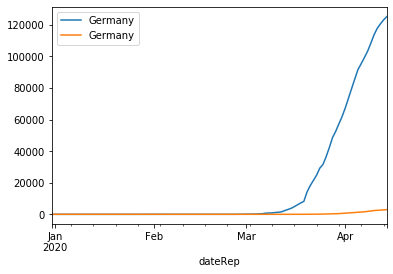

In [42]:
# gca stands for 'get current axis'
ax = plt.gca()

df_cases_piv.plot(kind='line',x='dateRep',y='Germany',ax=ax)
df_deaths_piv.plot(kind='line',x='dateRep',y='Germany',ax=ax)


plt.show()

#### Data Preparation Next Steps

Further data adjustments are needed to answer the above stated questions of interest. These further data preparation activities will be performed "by question" to make it easier for the reader to follow the origianl train of thoughts. 

## 4. Data Understanding, Preparation, Modeling, Evaluation and Development by Question

The further steps of the CRISP-DM model are integrated into each of the 4 questions (see chapter Business Understanding)